In [1]:
import torch
from diffusers import StableDiffusionPipeline


/Users/nic261/Environments/general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:

model_path = '/Users/nic261/Checkpoints/stanford/roentgen/'
pipe = StableDiffusionPipeline.from_pretrained(model_path).to(device)


Loading pipeline components...:  71%|███████▏  | 5/7 [00:01<00:00,  3.69it/s]/Users/nic261/Environments/general/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]


In [4]:
prompt = 'big left-sided pleural effusion'

output = pipe([prompt], num_inference_steps=75, height=512, width=512, guidance_scale=4)

100%|██████████| 75/75 [00:31<00:00,  2.40it/s]


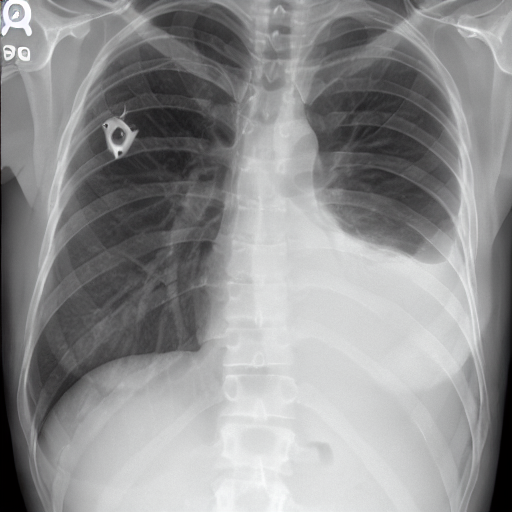

In [5]:
output.images[0]

In [6]:
type(output.images[0])

PIL.Image.Image

In [7]:
del pipe

In [8]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-single-tf'

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)



A new version of the following files was downloaded from https://huggingface.co/aehrc/cxrmate-single-tf:
- modelling_single.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Some weights of SingleCXREncoderDecoderModel were not initialized from the model checkpoint at aehrc/cxrmate-single-tf and are newly initialized: ['decoder.bert.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/nic261/Environments/general/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [9]:
image = test_transforms(output.images[0])

images = torch.stack([image], dim=0)

In [10]:


outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    special_token_ids=[tokenizer.sep_token_id],
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=4,
)
outputs.sequences



/Users/nic261/Environments/general/lib/python3.11/site-packages/transformers/generation/utils.py:723: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  input_ids = input_ids.repeat_interleave(expand_size, dim=0)
/Users/nic261/Environments/general/lib/python3.11/site-packages/transformers/generation/beam_search.py:357: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  sent_lengths_max = sent_lengths.max().item() + 1


tensor([[   1,   40,  182,   22,  580, 1259,   22,   40,   22, 1257,  739,  282,
          115, 1204,  820,   23,  139,  428,  306,  120,  237,   23,  139,  386,
          148,  356,  349,  150,  437,  237,  526,   23,  213,  120,  163,  211,
           21,  322,  284,   21,  214,  183,  171,   23,    3,  159,  271,  916,
          389,   23,    2]], device='mps:0')

In [11]:
# Findings and impression sections (exclude previous impression section):
findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer,
)
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: A right-sided Port-A-Cath terminates at the cavoatrial junction. The heart size is normal. The hilar and mediastinal contours are within normal limits. There is no pneumothorax, focal consolidation, or pleural effusion.
Impression: No acute intrathoracic process.

